In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from scipy.stats import wasserstein_distance
from jax import jit

rng = np.random.default_rng(seed = 123)

In [4]:
def cdf_distance(p, u_values, v_values, u_weights=None, v_weights=None):
    r"""
    Compute, between two one-dimensional distributions :math:`u` and
    :math:`v`, whose respective CDFs are :math:`U` and :math:`V`, the
    statistical distance that is defined as:

    .. math::

        l_p(u, v) = \left( \int_{-\infty}^{+\infty} |U-V|^p \right)^{1/p}

    p is a positive parameter; p = 1 gives the Wasserstein distance, p = 2
    gives the energy distance.

    Parameters
    ----------
    u_values, v_values : array_like
        Values observed in the (empirical) distribution.
    u_weights, v_weights : array_like, optional
        Weight for each value. If unspecified, each value is assigned the same
        weight.
        `u_weights` (resp. `v_weights`) must have the same length as
        `u_values` (resp. `v_values`). If the weight sum differs from 1, it
        must still be positive and finite so that the weights can be normalized
        to sum to 1.

    Returns
    -------
    distance : float
        The computed distance between the distributions.

    Notes
    -----
    The input distributions can be empirical, therefore coming from samples
    whose values are effectively inputs of the function, or they can be seen as
    generalized functions, in which case they are weighted sums of Dirac delta
    functions located at the specified values.

    References
    ----------
    .. [1] Bellemare, Danihelka, Dabney, Mohamed, Lakshminarayanan, Hoyer,
           Munos "The Cramer Distance as a Solution to Biased Wasserstein
           Gradients" (2017). :arXiv:`1705.10743`.

    """
    # u_values, u_weights = _validate_distribution(u_values, u_weights)
    # v_values, v_weights = _validate_distribution(v_values, v_weights)

    u_sorter = np.argsort(u_values)
    v_sorter = np.argsort(v_values)

    all_values = np.concatenate((u_values, v_values))
    all_values.sort(kind='mergesort')

    # Compute the differences between pairs of successive values of u and v.
    deltas = np.diff(all_values)

    # Get the respective positions of the values of u and v among the values of
    # both distributions.
    u_cdf_indices = u_values[u_sorter].searchsorted(all_values[:-1], 'right')
    v_cdf_indices = v_values[v_sorter].searchsorted(all_values[:-1], 'right')

    # Calculate the CDFs of u and v using their weights, if specified.
    if u_weights is None:
        u_cdf = u_cdf_indices / u_values.size
    else:
        u_sorted_cumweights = np.concatenate(([0],
                                              np.cumsum(u_weights[u_sorter])))
        u_cdf = u_sorted_cumweights[u_cdf_indices] / u_sorted_cumweights[-1]

    if v_weights is None:
        v_cdf = v_cdf_indices / v_values.size
    else:
        v_sorted_cumweights = np.concatenate(([0],
                                              np.cumsum(v_weights[v_sorter])))
        v_cdf = v_sorted_cumweights[v_cdf_indices] / v_sorted_cumweights[-1]

    # Compute the value of the integral based on the CDFs.
    # If p = 1 or p = 2, we avoid using np.power, which introduces an overhead
    # of about 15%.
    if p == 1:
        return np.sum(np.multiply(np.abs(u_cdf - v_cdf), deltas))
    if p == 2:
        return np.sqrt(np.sum(np.multiply(np.square(u_cdf - v_cdf), deltas)))
    return np.power(np.sum(np.multiply(np.power(np.abs(u_cdf - v_cdf), p),
                                       deltas)), 1/p)


In [2]:
def pairwise_dists(point_cloud, squared = False):
    norms = jnp.sum(jnp.square(point_cloud), axis = 1)
    dists_sq = jnp.maximum(norms[:, None] + norms[None, :] - 2 * point_cloud @ point_cloud.T, 0)
    if squared:
        return dists_sq
    else:
        return jnp.sqrt(dists_sq)
# dist_1 = np.array([0., 1., 2.])
# dist_2 = np.array([0.5, 1.5])
N_x, N_y = 200, 200
x = rng.normal(size = (N_x, 2))
y = rng.normal(size = (N_y, 3))

dists_x = pairwise_dists(x)
dists_y = pairwise_dists(y)
# cdf_distance(p = 2, u_values = dist_1, v_values = dist_2)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
def get_histogram_distances(dists_x, dists_y):
    N_x, N_y = dists_x.shape[0], dists_y.shape[0]
    dists_x_sorter = jnp.argsort(dists_x, axis = 1)
    dists_y_sorter = jnp.argsort(dists_y, axis = 1)

    dists_x_sorted = jnp.take_along_axis(dists_x, dists_x_sorter, axis = 1)
    dists_y_sorted = jnp.take_along_axis(dists_y, dists_y_sorter, axis = 1)

    dists_x_wide = jnp.tile(dists_x_sorted[:, None, :], [1, N_y, 1])
    dists_y_wide = jnp.tile(dists_y_sorted[None, :, :], [N_x, 1, 1])

    all_values = jnp.concatenate([dists_x_wide, dists_y_wide], axis = 2)
    all_values_sorter = jnp.argsort(all_values, axis = 2)
    # all_values_index_finder = jnp.argsort(all_values_sorter, axis = 2)

    # These two methods should be equivalent. I'm not sure which is faster
    # all_values_sorted = jnp.sort(all_values)
    all_values_sorted = jnp.take_along_axis(all_values, all_values_sorter, axis = 2) # I'm guessing this one
    deltas = jnp.diff(all_values_sorted, axis = 2)

    # dist_x_pdf_indices = all_values_index_finder[:, :, :N_x]
    # dist_y_pdf_indices = all_values_index_finder[:, :, N_x:]

    dist_x_pdf = jnp.concatenate([jnp.ones(dists_x_wide.shape), jnp.zeros(dists_y_wide.shape)], axis = 2)
    dist_y_pdf = jnp.concatenate([jnp.zeros(dists_x_wide.shape), jnp.ones(dists_y_wide.shape)], axis = 2)

    dist_x_pdf = jnp.take_along_axis(dist_x_pdf, all_values_sorter, axis = 2) / N_x
    dist_y_pdf = jnp.take_along_axis(dist_y_pdf, all_values_sorter, axis = 2) / N_y

    dist_x_cdf = jnp.cumsum(dist_x_pdf, axis = 2)[:, :, :-1]
    dist_y_cdf = jnp.cumsum(dist_y_pdf, axis = 2)[:, :, :-1]

    hist_dis_xy = jnp.sum(jnp.multiply(jnp.abs(dist_x_cdf - dist_y_cdf), deltas), axis = 2)
    return hist_dis_xy

jit_histogram_distances = jit(get_histogram_distances)


In [8]:
# get_histogram_distances(dists_x, dists_y)
jit_histogram_distances(dists_x, dists_y)

Array([[0.3829897 , 0.08608823, 0.820945  , ..., 0.374511  , 0.36881202,
        0.30060112],
       [0.34097645, 0.110889  , 0.77603734, ..., 0.33019018, 0.32477453,
        0.25647563],
       [0.46761823, 0.16142243, 0.9055736 , ..., 0.45913953, 0.45344073,
        0.38543075],
       ...,
       [0.32063705, 0.66667104, 0.15111683, ..., 0.32663924, 0.33690205,
        0.40595856],
       [0.69335747, 0.3473632 , 1.1313128 , ..., 0.68487835, 0.6791797 ,
        0.6109711 ],
       [0.62525475, 0.28649467, 1.0632101 , ..., 0.61677593, 0.6110772 ,
        0.5428711 ]], dtype=float32)

In [202]:
wasserstein_distance(dists_x[0], dists_y[0])

1.5787187178929647

In [197]:
u_values = np.array(dists_x[0])
v_values = np.array(dists_y[0])

u_weights = None
v_weights = None

u_sorter = np.argsort(u_values)
v_sorter = np.argsort(v_values)

all_values_unsorted = np.concatenate((u_values[u_sorter], v_values[v_sorter]))
all_values_sorter = np.argsort(all_values_unsorted)
all_values = np.sort(all_values_unsorted, kind='mergesort')

# Compute the differences between pairs of successive values of u and v.
deltas = np.diff(all_values)

# Get the respective positions of the values of u and v among the values of
# both distributions.
u_cdf_indices = u_values[u_sorter].searchsorted(all_values[:-1], 'right')
v_cdf_indices = v_values[v_sorter].searchsorted(all_values[:-1], 'right')

# Calculate the CDFs of u and v using their weights, if specified.
if u_weights is None:
    u_cdf = u_cdf_indices / u_values.size
else:
    u_sorted_cumweights = np.concatenate(([0],
                                            np.cumsum(u_weights[u_sorter])))
    u_cdf = u_sorted_cumweights[u_cdf_indices] / u_sorted_cumweights[-1]

if v_weights is None:
    v_cdf = v_cdf_indices / v_values.size
else:
    v_sorted_cumweights = np.concatenate(([0],
                                            np.cumsum(v_weights[v_sorter])))
    v_cdf = v_sorted_cumweights[v_cdf_indices] / v_sorted_cumweights[-1]

In [198]:
# u_cdf
# deltas
# u_values
# v_values
# all_values.shape
u_cdf
# v_cdf
# all_valuesnp.array([0, 1, 2])

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.6, 0.7, 0.8, 0.9, 0.9, 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ])

In [200]:
dist_x_cdf[0, 0] - u_cdf

Array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       5.9604645e-08, 0.0000000e+00, 5.9604645e-08, 5.9604645e-08,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],      dtype=float32)

In [124]:
# u_cdf_indices
# all_values_reverse_sorter = np.empty(all_values_sorter.size, dtype = np.int32)
all_values_reverse_sorter = np.argsort(all_values_sorter)

u_ind = all_values_reverse_sorter[:3]
u_pdf = np.zeros(all_values.shape)
u_pdf[u_ind] = 1. / u_ind.shape[0]
u_cdf = np.cumsum(u_pdf)
u_cdf
# print(u_values[u_sorter])
# print(all_values_unsorted)
# print(all_values_sorter)
# print(all_values_reverse_sorter)
# print(u_cdf_indices)

array([0.33333333, 0.33333333, 0.66666667, 0.66666667, 1.        ])

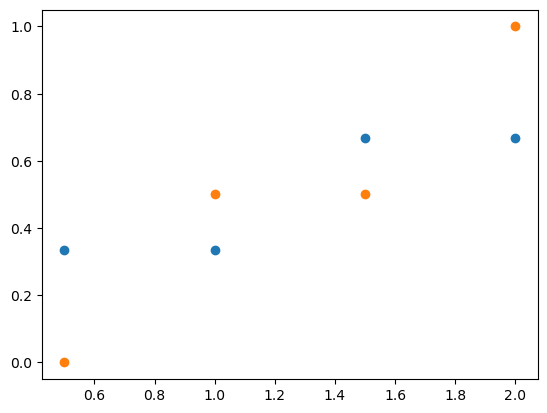

In [19]:
plt.scatter(np.cumsum(deltas), u_cdf)
plt.scatter(np.cumsum(deltas), v_cdf)